# How do machines understand language?

© Explore Data Science Academy

## Learning Objectives

- Gain a basic understanding of text cleaning;
- Understand how to extract features from text.

## Outline
In this train we will cover:
- The NLTK Library
- The MBTI Dataset
- Text Cleaning
    - Removing Noise
    - Tokenisation
    - Stemming 
    - Lemmatisation
    - Stop Words  
- Text Feature Extraction 
    - n-grams
    - Bag of words 

## Introduction

This tutorial introduces basic concepts in Natural Language Processing. Particularly common techniques for handling, processing and preparing unstructured text data for use with machine learning models. The concepts introduced here are also very useful for text analysis, so please feel free to do more research and see if you can implement these with the MBTI dataset.

Before we get started, lets get the data and the main library we will be using.

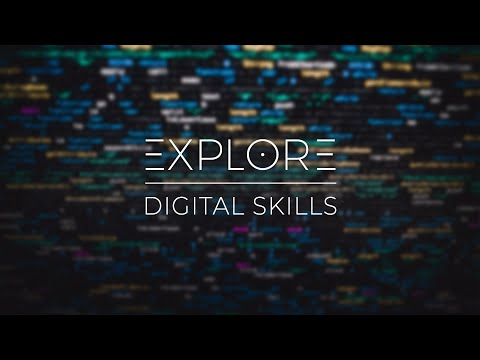

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('FStga4wGpmo', width=940, height=500)

## NLTK

NLTK - Natural Language Toolkit - is a leading library for building Python programs to work with human language data. It provides easy-to-use interfaces to over 50 corpora and lexical resources, such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning, wrappers for industrial-strength NLP libraries, and an active discussion forum.

Thanks to a hands-on guide introducing programming fundamentals alongside topics in computational linguistics, plus comprehensive API documentation, NLTK is suitable for linguists, engineers, students, educators, researchers, and industry users alike. NLTK is available for Windows, Mac OS X, and Linux. Best of all, NLTK is a free, open source, community-driven project.

Let's import `nltk` and other packages to get started.

In [ ]:
import nltk

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

# set plot style
sns.set()

### Downloading NLTK Corpora

Some of the `nltk` text processing methods introduced in this train involve a lookup operation. For example, to find all [stopwords](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/) in a given string of text, we require a list of all possible stopwords in the English language to use for the lookup. Such a list is refered to as a [corpus](https://en.wikipedia.org/wiki/Text_corpus). Therefore, we need to first download the corpora we're going use, otherwise we may get a lookup error! Watch out specifically for the `tokenize` and `stopwords` sections. Not to worry, as we can easily avoid these errors by downloading the [corpora](http://www.nltk.org/nltk_data/) using the `nltk` downloader tool:

In [ ]:
nltk.download()

You should see this pop-up box. 

**NOTE:** the box might pop-up in the backround, in which case you should use `alt + tab` to switch to the downloader window.

<img src="https://github.com/Explore-AI/Pictures/blob/master/nltk_downloader.png?raw=true" width=50%/> 

Use it to navigate to the item we need to download: 
- stopwords corpus (Corpora tab)
- punkt tokenizer models (Models tab)

Navigate to these, click the download button, and exit the downloader when finished.

In [ ]:
# or you can download directly, i.e.
#nltk.download(['punkt','stopwords'])

If the download was successful, then the following import should work:

In [ ]:
from nltk.corpus import stopwords

Although we'll explore stopwords in greater detail later in this train, it won't hurt to take a quick look at what we've downloaded:

In [ ]:
stopwords_list = stopwords.words('english')
print(stopwords_list)

## The MBTI dataset

The Myers Briggs Type Indicator (or MBTI for short) is a personality type system that divides people into one of 16 distinct personality types across 4 axes:

    Introversion (I) – Extroversion (E)
    Intuition (N) – Sensing (S)
    Thinking (T) – Feeling (F)
    Judging (J) – Perceiving (P)

[(More can be learned about what these mean here)](https://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/home.htm)

So for example, someone who prefers introversion, intuition, thinking and perceiving would be labelled an INTP in the MBTI system, and there are lots of personality based components that would model or describe this person’s preferences or behaviour based on the label.

<img src='https://upload.wikimedia.org/wikipedia/commons/1/1f/MyersBriggsTypes.png'>Image by <a href="//commons.wikimedia.org/wiki/User:JakeBeech" title="User:JakeBeech">Jake Beech</a> - <span class="int-own-work" lang="en"></span><a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>

In this train, we'll use a version of [the MBTI dataset](https://www.kaggle.com/datasnaek/mbti-type) which contains over 6000 rows of data, on each row is a person’s:

 - Type (This person's 4 letter MBTI code)
 - A section of each of the last 50 things they have posted online (Each entry separated by "|||" (3 pipe characters))      
 
_**Note:** If you are curious, you can find out what your MBTI personality is by taking the test here: https://www.16personalities.com/_

### Let's get the data and clean it up a bit

In [ ]:
mbti = pd.read_csv('https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Data/classification_sprint/mbti_train.csv')
mbti.head()

We'll print off a list of all the MBTI personality types which are present in this dataset.

In [ ]:
type_labels = list(mbti.type.unique())
print(type_labels)

Let's have a look at how many data samples we have for each of the different MBTI personality types.

In [ ]:
mbti['type'].value_counts().plot(kind = 'bar')
plt.show()

It looks like we have very few samples for the 'ES' types. Maybe because they are out in the real-world, not sitting behind a computer screen! :)   
   
Let's increase the size of the dataset by separating each of the 50 posts in the `posts` column of each row into its own row. 

In [ ]:
all_mbti = []
for i, row in mbti.iterrows():
    for post in row['posts'].split('|||'):
        all_mbti.append([row['type'], post])
all_mbti = pd.DataFrame(all_mbti, columns=['type', 'post'])

In [ ]:
# how many rows do we have now?
all_mbti.shape

In [ ]:
all_mbti['type'].value_counts().plot(kind = 'bar')
plt.show()

The proportions of the classes remain the same, but we now have a much larger number of samples for the 'ES' personality types.

## Text Cleaning

### Removing Noise

In text analytics, removing noise (i.e. unneccesary information) is a key part of getting the data into a usable format.  Some techniques are standard, but your own data will require some creative thinking on your part.

For the MBTI dataset we will be doing the following steps:
* removing the web-urls
* making everything lower case
* removing punctuation

**[Regular expressions](https://www.regular-expressions.info/)** can be very useful for extracting information from text.  If you feel brave, go teach yourself all about it... If not, just follow along.  This next step effectively removes all websites and replaces them with the text `'web-url'` 

In [ ]:
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
all_mbti['post'] = all_mbti['post'].replace(to_replace = pattern_url, value = subs_url, regex = True)

In [ ]:
all_mbti.head()

**Seed of an idea...** There seem to be a lot of YouTube and other links embedded.  Maybe you can think of ways to collect even more information from these links?  How about page titles and names of Youtube videos?

### Remove punctuation

First we make all the text lower case to remove some noise from capitalisation.

In [ ]:
all_mbti['post'] = all_mbti['post'].str.lower()

Now let's remove the punctuation using the `string` import.

In [ ]:
import string
print(string.punctuation)

In [ ]:
def remove_punctuation(post):
    return ''.join([l for l in post if l not in string.punctuation])

In [ ]:
all_mbti['post'] = all_mbti['post'].apply(remove_punctuation)
all_mbti['post'].iloc[268558]

Looks like some punctuation snuck through! See if you can figure out why? Hint it has something to do with the standard encoding on text files in python...

### Tokenisation

A tokeniser divides text into a sequence of tokens, which roughly correspond to "words" (see the [Stanford Tokeniser](https://nlp.stanford.edu/software/tokenizer.html)). We will use tokenisers to clean up the data, making it ready for analysis.

In [ ]:
from nltk.tokenize import word_tokenize, TreebankWordTokenizer

In [ ]:
word_tokenize('A tokenizer divides text into a sequence of tokens, which roughly correspond to "words".')

We will use the TreeBankWordTokenizer since it is MUCH quicker than the word_tokenize function.

In [ ]:
tokeniser = TreebankWordTokenizer()
all_mbti['tokens'] = all_mbti['post'].apply(tokeniser.tokenize)

In [ ]:
all_mbti['tokens'].iloc[55555]

### Stemming

Stemming is the process of transforming to the root word. It uses an algorithm that removes
common word-endings from English words, such as “ly,” “es,” “ed,” and “s.” 

For example, assuming for an analysis you may want to consider “carefully,” “cared,” “cares,” “caringly” as “care” instead of separate words. There are three widely used stemming algorithms, namely:
* Porter
* Lancaster
* Snowball

Out of these three, we will be using the `SnowballStemmer`.

In [ ]:
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer

In [ ]:
words = 'caring cares cared caringly carefully'

In [ ]:
# find the stem of each word in words
stemmer = SnowballStemmer('english')
for word in words.split():
    print(stemmer.stem(word))

Now let us stem all of the words in the MBTI dataframe.

In [ ]:
def mbti_stemmer(words, stemmer):
    return [stemmer.stem(word) for word in words]

In [ ]:
all_mbti['stem'] = all_mbti['tokens'].apply(mbti_stemmer, args=(stemmer, ))

Print off the results of the stemmer to see what we have done.

In [ ]:
for i, t in enumerate(all_mbti.iloc[268702]['tokens']):    
    print ('{:20s} --> {:10s}'.format(t, all_mbti.iloc[268702]['stem'][i]))

### Lemmatization

A very similar operation to stemming is called lemmatization. Lemmatizing is the process of grouping words of similar meaning together. So, your root stem, meaning the word you end up with, is not something you can just look up in a dictionary, but you can look up a lemma.

Sometimes you will wind up with a very similar word, but other times you will wind up with a completely different word. Let's see some examples.

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

print(lemmatizer.lemmatize("cats"))
print(lemmatizer.lemmatize("cacti"))
print(lemmatizer.lemmatize("geese"))
print(lemmatizer.lemmatize("rocks"))
print(lemmatizer.lemmatize("python"))
print(lemmatizer.lemmatize("better", pos="a"))
print(lemmatizer.lemmatize("best", pos="a"))
print(lemmatizer.lemmatize("run"))
print(lemmatizer.lemmatize("ran",'v'))

Let's lemmatize all of the words in the MBTI dataframe.

In [ ]:
def mbti_lemma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]    

In [ ]:
all_mbti['lemma'] = all_mbti['tokens'].apply(mbti_lemma, args=(lemmatizer, ))

Now we will print out the results of the lemmatization to see what we have done.

In [ ]:
for i, t in enumerate(all_mbti.iloc[268702]['tokens']):    
    print ('{:20s} --> {:10s}'.format(t, all_mbti.iloc[268702]['lemma'][i]))

### Stop Words

Stop words are words which do not contain important significance to be used in Search Queries. Usually these words are filtered out from search queries because they return a vast amount of unnecessary information. `nltk` has a corpus of stopwords. Let's print out the stopwords for English.

In [ ]:
from nltk.corpus import stopwords
print(stopwords.words('english'))

In [ ]:
sorted(stopwords.words('english'))[0:10]

The following function removes all of the English stopwords from the input text.

In [ ]:
def remove_stop_words(tokens):    
    return [t for t in tokens if t not in stopwords.words('english')]

Let's leave the stop words in for now so that we can test the following **Hypothesis**:
* Introverts tend to use the word **`I`** more than extroverts
* Conversely, Extroverts tend to favour the word **`you`**

In case you want to run the analysis again without stop words, uncomment and run the following cell! Be warned, this can take long with the pandas apply function

In [ ]:
# all_mbti['stem'] = all_mbti['tokens'].apply(remove_stop_words)

Let's learn about text feature extraction and how these methods will help us test our hypothesis.

## Text feature extraction

### Bag of words

Text feature extraction is the process of transforming what is essentially a list of words into a feature set that is usable by a classifier. The NLTK classifiers expect `dict` style feature sets, so we must therefore transform our text into a `dict`. The Bag of Words model is the simplest method; it constructs a word presence feature set from all the words in the text, indicating the number of times each word has appeared.

In [ ]:
def bag_of_words_count(words, word_dict={}):
    """ this function takes in a list of words and returns a dictionary 
        with each word as a key, and the value represents the number of 
        times that word appeared"""
    for word in words:
        if word in word_dict.keys():
            word_dict[word] += 1
        else:
            word_dict[word] = 1
    return word_dict

Here we create a set of dictionaries, one for each of the MBTI types.

In [ ]:
personality = {}
for pp in type_labels:
    df = all_mbti.groupby('type')
    personality[pp] = {}
    for row in df.get_group(pp)['tokens']:
        personality[pp] = bag_of_words_count(row, personality[pp])       

Next, we create a list of all of the unique words.

In [ ]:
all_words = set()
for pp in type_labels:
    for word in personality[pp]:
        all_words.add(word)

This was done so that we can create a combined bag of words dictionary for all the words in the text.

In [ ]:
personality['all'] = {}
for pp in type_labels:    
    for word in all_words:
        if word in personality[pp].keys():
            if word in personality['all']:
                personality['all'][word] += personality[pp][word]
            else:
                personality['all'][word] = personality[pp][word]

Now we can easily calculate how many words there are in total.

In [ ]:
total_words = sum([v for v in personality['all'].values()])
total_words

Let's take a look at the distribution of words which occur less than 10 times in the whole dataset.

In [ ]:
_ = plt.hist([v for v in personality['all'].values() if v < 10],bins=10)
plt.ylabel("# of words")
plt.xlabel("word frequency")

There are a lot of words that only appear once! We'll print out that value here.

In [ ]:
len([v for v in personality['all'].values() if v == 1])

What kind of words do you think would appear once out of roughly 8 million words? Let's print out a few of these rare words.

In [ ]:
rare_words = [k for k, v in personality['all'].items() if v==1] 
print(rare_words[:100])

As you can see, some of these words don't make sense, but before we decide to remove them, let's see how much data we'll be left with.

In [ ]:
# how many words appear more than 10 times?
# how many words of the total does that account for?
print(len([v for v in personality['all'].values() if v >= 10]))
occurs_more_than_10_times = sum([v for v in personality['all'].values() if v >= 10])
print(occurs_more_than_10_times)

In [ ]:
occurs_more_than_10_times/total_words

Using words that appear more than 10 times seems much more useful!  And this accounts for 97% of all the words!

Finally, let's remove all words that occur less than 10 times.

In [ ]:
max_count = 10
remaining_word_index = [k for k, v in personality['all'].items() if v > max_count]

### Hypothesis testing
Remember our Hypothesis from earlier?:

- Introverts tend to use the word `I` more than extroverts
- Conversely, Extroverts tend to favour the word `you`

Let's see if we finally have what we need to test it out. We'll first create one big dataframe with the word counts by personality profile (this may take a while).

In [ ]:
hm = []
for p, p_bow in personality.items():
    df_bow = pd.DataFrame([(k, v) for k, v in p_bow.items() if k in remaining_word_index], columns=['Word', p])
    df_bow.set_index('Word', inplace=True)
    hm.append(df_bow)

# create one big dataframe
df_bow = pd.concat(hm, axis=1)
df_bow.fillna(0, inplace=True)

What are the top 10 words which appear most often?

In [ ]:
df_bow.sort_values(by='all', ascending=False).head(10)

This isn't very helpful at all, is it? It's very difficult to extract insights from this data.  Let's see if we can use the $chi^2$ test to see whether Introverts favour the word **`I`**. We'll do this first by extracting introvert types only from all the personality types.

In [ ]:
intro_types = [p for p in type_labels if p[0] == 'I']

Next, we'll create an introvert total word count column, which sums the counts of all introvert columns.

In [ ]:
df_bow['I'] = df_bow[intro_types].sum(axis=1)

Now we'll calculate and add percentage columns.

In [ ]:
for col in ['I', 'all']:
    df_bow[col+'_perc'] = df_bow[col] / df_bow[col].sum()

Print off the dataframe to view what we've done.

In [ ]:
df_bow.sort_values(by='all', ascending=False).head(5)

Do you remember the $chi^2$ test from the CINDY framework?  This looks at observed versus expected results and lets us know where the greatest differences from expected values are.  The bigger the statistic, the greater the difference from expectation.  The formula is 

$$𝑐ℎ𝑖^2 = \sum{\frac{(𝑂𝑏𝑠𝑒𝑟𝑣𝑒𝑑 −𝑒𝑥𝑝𝑒𝑐𝑡𝑒𝑑)^2}{𝑒𝑥𝑝𝑒𝑐𝑡𝑒𝑑}}$$

In [ ]:
# calculate chi2
df_bow['chi2'] = np.power((df_bow['I_perc'] - df_bow['all_perc']), 2) / df_bow['all_perc']

In [ ]:
df_bow[['I_perc', 'all_perc', 'chi2']][df_bow['I_perc'] > df_bow['all_perc']].sort_values(by='chi2', ascending=False).head(10)

And there it is! What can we conclude from this:
* `I` is the 9th most introverted word, by expectation
* Introverts tend to post more urls than extroverted people! 
* The introverted types are more likely to be written by Introverts, maybe because people post about their own personality types?

Let's now have a look at the words most used by extroverts.

In [ ]:
df_bow[['I_perc', 'all_perc', 'chi2']][df_bow['I_perc'] < df_bow['all_perc']].sort_values(by='chi2', ascending=False).head(15)

What can we conclude from this:
* `you` is the 12th most extroverted word. 
* The extroverted types are more likely to be written by Extroverts, again showing that people post about their own personality types.

These suggest that, in these posts, extroverts would be interacting with other people while introverts seem to discuss themselves, their interests or experiences.

### ngrams

While individual words do carry meaning, it is often the case that combinations of words change meanings of sentences entirely.  For example, what difference does removing the `not` from this sentence make?

Natural Language Processing is **not** easy!

ngrams are a method to extract combinations of words into features for model buildiing.  The `n` in ngrams specifies the number of tokens to include.  For example, a 2-gram returns all the consecutive pairs of words in a sentence.

In [ ]:
from nltk.util import ngrams

In [ ]:
def word_grams(words, min_n=1, max_n=4):
    s = []
    for n in range(min_n, max_n):
        for ngram in ngrams(words, n):
            s.append(' '.join(str(i) for i in ngram))
    return s

In [ ]:
print (word_grams('one two three four'.split(' ')))

Let's combine consecutive words into groups of 2 using ngrams.

In [ ]:
[x for x in ngrams(all_mbti.iloc[55555]['tokens'], 2)]

Now let's combine consecutive words into groups of 3 using ngrams.

In [ ]:
[x for x in ngrams(all_mbti.iloc[55555]['tokens'], 3)]

## Now that we understand all of that, let's cheat!

Praise be to Python...

`sklearn` has a built in text feature extraction module called [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) that will literally do all of that work in one line of code! This function will convert a collection of documents (rows of text) into a matrix of token counts.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vect = CountVectorizer()
vect.fit(all_mbti['post'])

### Tuning the vectorizer

We have been using the default parameters of [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). However, the vectorizer is worth tuning, just like a model is worth tuning! Here are a few parameters that you might want to tune with examples on how to do so:

- **stop_words:** string 'english', list, or None (default)
    * If 'english', a built-in stop word list for English is used.
    * If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens.
    * If None, no stop words will be used.

In [ ]:
# remove English stop words
vect = CountVectorizer(stop_words='english')

- **ngram_range:** tuple (min_n, max_n), default=(1, 1)
    - The lower and upper boundary of the range of n-values for different n-grams to be extracted.
    - All values of n such that min_n <= n <= max_n will be used.

In [ ]:
# include 1-grams and 2-grams
vect = CountVectorizer(ngram_range=(1, 2))

- **max_df:** float in range [0.0, 1.0] or int, default=1.0
    - When building the vocabulary, ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

In [ ]:
# ignore terms that appear in more than 50% of the documents
vect = CountVectorizer(max_df=0.5)

- **min_df:** float in range [0.0, 1.0] or int, default=1
    - When building the vocabulary, ignore terms that have a document frequency strictly lower than the given threshold. (This value is also called "cut-off" in the literature.)
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

In [ ]:
# only keep terms that appear in at least 2 documents
vect = CountVectorizer(min_df=2)

### Guidelines for tuning CountVectorizer:

- Use your knowledge of the **problem** and the **text**, and your understanding of the **tuning parameters**, to help you decide what parameters to tune and how to tune them.
- **Experiment**, and let the data tell you the best approach!

Finally, let's fit a tuned CountVectorizer to the MBTI data.

In [ ]:
betterVect = CountVectorizer(stop_words='english', 
                             min_df=2, 
                             max_df=0.5, 
                             ngram_range=(1, 1))

In [ ]:
betterVect.fit(all_mbti['post'])

## Conclusion

In this train we covered various techniques for cleaning text data and extracting features to use with machine learning models. We also demonstrated how NLTK's `CountVectorizer` can be used to clean text data and extract features, transforming the text data into a matrix of numbers that can be fed into a machine learning model.